# HumanAi Google Summer of Code Test Submission: Task 2

### **Why a Transformer Based Model?**

* CNNs are excellent for detecting small patterns in images, such as individual letters and words (if we wanted to identify the embellishments).

* Transformers help the model understand the broader layout of the text, making it better at distinguishing real content from unnecessary embellishments.

* This approach has shown strong performance in document layout analysis and text recognition.

### **Training Strategy**

To train the model effectively, I decided to use the following strategy:

* Loss Function: I combined Binary Cross-Entropy (BCE) Loss with Dice Loss to ensure better text segmentation.

* Evaluation Metric: I used Intersection over Union (IoU) to measure how well the model identifies text areas.

* Optimizer: I implemented the Adam optimizer with a learning rate scheduler to adjust the learning process dynamically.

### **Evaluation Metrics**

* Intersection over Union (IoU)
IoU measures how well the predicted text mask overlaps with the actual text mask.
It helps penalize both false positives (wrong areas predicted as text) and false negatives (missed text).
A higher IoU (closer to 1) means better segmentation.

* Dice Loss
Helps when one class (text) is much smaller than the other (background).
Encourages the model to focus on small text regions.
Works similarly to IoU but gives more weight to correct predictions.

* Binary Cross-Entropy (BCE) Loss
Treats each pixel as a separate classification problem.
Penalizes incorrect predictions more aggressively.
Works well with sigmoid activation to produce probability outputs.

### **Final Training Vs Evaluation Metrics**

* Train the model using BCE Loss + Dice Loss.

* Monitor IoU after each epoch.

* Stop training early if IoU stops improving.

* Ensure the model focuses on text areas while ignoring background noise.

### **Results**
* Loss is decreasing: This shows that the model is learning and getting better at minimizing its errors over time.
* IoU is increasing: This indicates that the model is improving its ability to correctly segment the relevant areas of the image.

This is further confirmed by my graphs
* Training Loss Graph: A decreasing curve as the model learns.
* IoU Graph: An increasing curve, as higher IoU means better segmentation.




In [21]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [22]:
class LayoutDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, "images")
        self.mask_dir = os.path.join(root_dir, "masks")
        self.transcription_dir = os.path.join(root_dir, "transcriptions")
        self.transform = transform
        self.image_names = sorted(os.listdir(self.image_dir))  # keep files in consistent order
        
    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        # load image and corresponding mask
        img_filename = self.image_names[idx]
        img_path = os.path.join(self.image_dir, img_filename)
        mask_path = os.path.join(self.mask_dir, img_filename)

        # open images
        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            # ensure mask is strictly binary
            mask = (mask > 0.5).float()

        return image, mask


In [23]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.1):
        super(TransformerBlock, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
    def forward(self, x):
        # reshape for transformer: [B,C,H,W] -> [H*W,B,C]
        B, C, H, W = x.shape
        x = x.view(B, C, H*W).permute(2, 0, 1)
        x = self.transformer_encoder(x)
        # reshape back to original dimensions
        x = x.permute(1, 2, 0).view(B, C, H, W)
        return x


In [24]:
class UNetTransformer(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512], nhead=8):
        super(UNetTransformer, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # downsample path (encoder)
        prev_channels = in_channels
        for feature in features:
            self.downs.append(self.conv_block(prev_channels, feature))
            prev_channels = feature

        # bottleneck with expanded features and transformer
        self.bottleneck = self.conv_block(features[-1], features[-1]*2)
        self.transformer = TransformerBlock(d_model=features[-1]*2, nhead=nhead)

        # upsample path (decoder)
        rev_features = features[::-1]
        current_channels = features[-1]*2
        for feature in rev_features:
            self.ups.append(
                nn.ConvTranspose2d(current_channels, feature, kernel_size=2, stride=2)
            )
            self.ups.append(self.conv_block(feature * 2, feature))
            current_channels = feature

        self.final_conv = nn.Conv2d(rev_features[-1], out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        skip_connections = []
        
        # encoder path
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
            
        # bottleneck with transformer
        x = self.bottleneck(x)
        x = self.transformer(x)
        
        # decoder path
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = nn.functional.interpolate(x, size=skip_connection.shape[2:])
            x = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](x)
            
        return self.final_conv(x)


In [25]:
def dice_loss(pred, target, smooth=1e-6):
    """Dice loss for better segmentation performance"""
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum(dim=(1,2,3))
    dice = (2. * intersection + smooth) / (pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) + smooth)
    return 1 - dice.mean()

def iou_score(pred, target, smooth=1e-6):
    """Intersection over Union metric"""
    pred = (torch.sigmoid(pred) > 0.5).float()
    intersection = (pred * target).sum(dim=(1,2,3))
    union = (pred + target - pred * target).sum(dim=(1,2,3))
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean().item()


In [26]:
def train_model(model, dataloader, optimizer, num_epochs=10, device="cuda"):
    model.train()
    criterion = nn.BCEWithLogitsLoss() 

    epoch_losses = []
    epoch_ious = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks) + dice_loss(outputs, masks)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader)

        epoch_losses.append(avg_loss)
        epoch_ious.append(iou_score(outputs, masks))
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, IoU: {iou_score(outputs, masks):.4f}")

    plot_training_progress(epoch_losses, epoch_ious)



In [27]:
def plot_training_progress(losses, ious):
    epochs = range(1, len(losses) + 1)
    
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, label="Loss", color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, ious, label="IoU", color='green')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.title('IoU Score Over Epochs')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Epoch [1/15], Loss: 1.1105, IoU: 0.5555
Epoch [2/15], Loss: 0.8781, IoU: 0.8402
Epoch [3/15], Loss: 0.7660, IoU: 0.8587
Epoch [4/15], Loss: 0.7129, IoU: 0.7784
Epoch [5/15], Loss: 0.6421, IoU: 0.9127
Epoch [6/15], Loss: 0.5940, IoU: 0.9014
Epoch [7/15], Loss: 0.5896, IoU: 0.7641
Epoch [8/15], Loss: 0.5491, IoU: 0.8699
Epoch [9/15], Loss: 0.5019, IoU: 0.8393
Epoch [10/15], Loss: 0.4595, IoU: 0.9342
Epoch [11/15], Loss: 0.4445, IoU: 0.8937
Epoch [12/15], Loss: 0.4090, IoU: 0.9431
Epoch [13/15], Loss: 0.3979, IoU: 0.9234
Epoch [14/15], Loss: 0.3700, IoU: 0.9466
Epoch [15/15], Loss: 0.3582, IoU: 0.9513


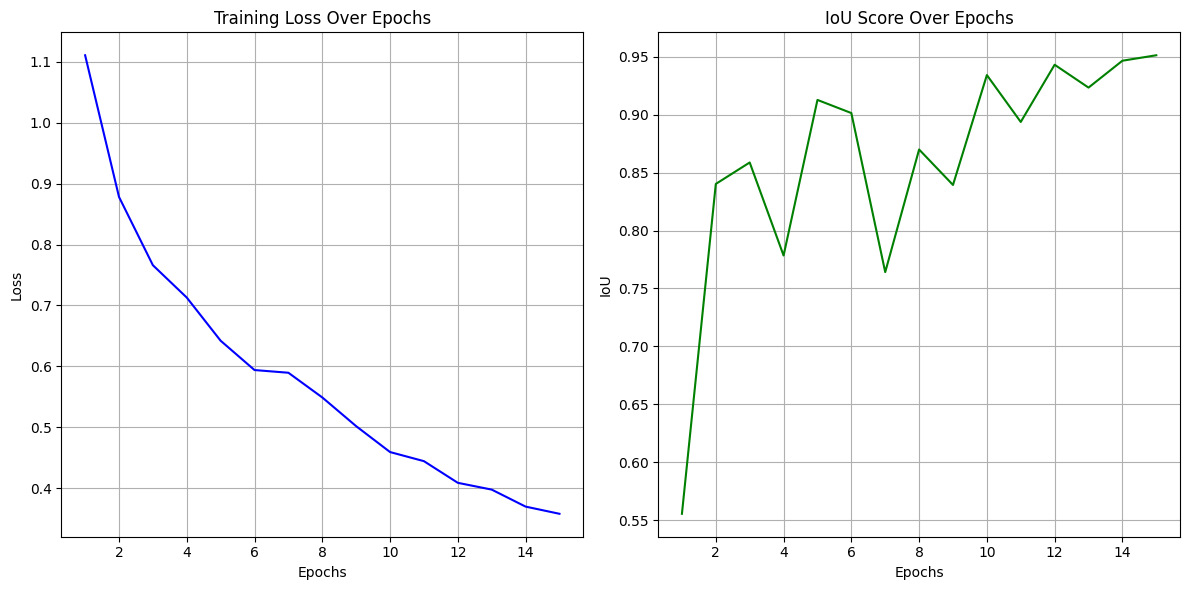

training is complete.


In [28]:
def main():
    # configuration settings
    root_dir = "./data"  
    batch_size = 4      
    num_epochs = 15 # training iterations
    learning_rate = 1e-4 
    device = "cuda" if torch.cuda.is_available() else "cpu"

    transform = transforms.Compose([
        transforms.Resize((256, 256)),  
        transforms.ToTensor(),    # Convert to PyTorch tensor
    ])

    dataset = LayoutDataset(root_dir=root_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    model = UNetTransformer(in_channels=1, out_channels=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_model(model, dataloader, optimizer, num_epochs=num_epochs, device=device)

    # save trained model
    torch.save(model.state_dict(), "unet_transformer_layout_model.pth")
    print("training is complete.")

if __name__ == "__main__":
    main()
